In [44]:
from elasticsearch import Elasticsearch
import ir_datasets
from tqdm import tqdm
from elasticsearch.helpers import bulk
import pandas as pd
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
from nltk.tokenize import word_tokenize


In [79]:
# INDEX = 'temp1'
INDEX = 'docs'
RETRIEVED_DOCS_INDEX = 'retrieved-docs'
DATASET_URI = 'clinicaltrials/2021'
QRELS_CSV = 'data/qrels2021.txt'
QUERIES_CSV = 'data/queries_2021.tsv'

MAX_NUMBER_OF_RETRIEVED_DOCS = 10_000

# Dataframes columns
DOC_ID = 'doc_id'
QUERY_ID = 'query_id'
QUERY_TEXT = 'query_text'
LABEL = 'label'

# Labels
ELIGIBLE = 2
EXCLUDED = 1
NON_RELEVANT = 0

# Similarity scores
BM25_DEFAULT = 'default'
ROBERTSON_BM25 = 'robertson'
LUCENE_ACCURATE = 'lucene-accurate'
ATIRE = 'atire'
BM25_PLUS = 'bm25plus'
BM25L = 'bm25l'
TFldpIDF = 'tfldpidf'



## BM25 Varriants similarity scripts

In [85]:
ROBERTSON_BM25_SCRIPT = '''
    double k1=1.2 ;
    double b=0.75;

    double avgLen = (double) field.sumTotalTermFreq / field.docCount;
    double tf = doc.freq / (doc.freq + k1 * (1 - b + b * doc.length / avgLen));
    double idf = Math.log((field.docCount - term.docFreq + 0.5) / (term.docFreq + 0.5));
    return idf * tf;
'''

LUCENE_ACCURATE_SCRIPT = '''
    double k1=1.2 ;
    double b=0.75;

    double avgLen = (double) field.sumTotalTermFreq / field.docCount;
    double tf = doc.freq / (doc.freq + k1 * (1 - b + b * doc.length / avgLen));
    double idf = Math.log(1 + (field.docCount - term.docFreq + 0.5) / (term.docFreq + 0.5));
    return idf * tf;
'''

BM25_PLUS_SCRIPT = '''
    double k1 = 1.2;
    b = 0.75;
    delta = 0.5;
    
    double avgLen = (double) field.sumTotalTermFreq / field.docCount;
    
    double idf = Math.log((field.docCount + 1) / (term.docFreq));
    double tf = ((k1+1)*doc.freq) / (k1 * (1 - b + b * (doc.length/avgLen)) + term.docFreq) + delta;
    
    return idf * tf;

'''

TFldpIDF_SCRIPT = '''
    double d = 0.5;
    double b = 0.75;
    
    double docLength = doc.length;
    double avgLen = (double) field.sumTotalTermFreq / field.docCount;
    double idf = Math.log((field.docCount + 1) / (term.docFreq));
    double tf = 1 + Math.log((doc.freq / (1 - b + b * (docLength / avgLen))) + d);
    double tf_nlgain = 1 + Math.log(tf);
    return idf * tf_nlgain;
'''


BM25L_SCRIPT = '''
    double d = 0.5;
    double k1=1.2 ;
    double b=0.75;
    
    double docLength = doc.length;
    double avgLen = (double) field.sumTotalTermFreq / field.docCount;
    double idf = Math.log((field.docCount + 1) / (term.docFreq + 0.5));
    double ctd = doc.freq / (1 - b + b * (doc.length / avgLen));
    double tf = ((k1 + 1) * (ctd + d)) / (k1 + ctd + d); 
    return idf * tf;
'''

ATIRE_SCRIPT = '''
    double k1 = 1.2;
    b = 0.75;
    double avgLen = (double) field.sumTotalTermFreq / field.docCount;
    
    double idf = Math.log(field.docCount / term.docFreq);
    double tf = ((k1+1)doc.freq) / (k1 * (1 - b + b(doc.length/avgLen)) + term.docFreq);
    
    return idf * tf;
'''


SIMILARITY_BY_NAME = {
    ROBERTSON_BM25: ROBERTSON_BM25_SCRIPT,
    BM25_PLUS: BM25_PLUS_SCRIPT,
    TFldpIDF: TFldpIDF_SCRIPT,
    BM25L: BM25L_SCRIPT,
    ATIRE: ATIRE_SCRIPT,
    LUCENE_ACCURATE: LUCENE_ACCURATE_SCRIPT,
}

## Connect to ElasticSearch

In [47]:
es = Elasticsearch()
es.ping()
es.indices.delete(INDEX)

{'acknowledged': True}

## Create index

In [48]:
mapping = {
   "settings":{
      "index":{
         "number_of_shards":1,
         "number_of_replicas":1
      },
   },
   "mappings":{
      "properties":{
         "content":{
            "type":"text",
            "fielddata":True,
            "term_vector":"with_positions_offsets_payloads",
            "store":True,
            "analyzer":"whitespace",
         }
      }
   }
}

In [49]:
es.indices.create(index=INDEX, ignore=400, body=mapping)

{'acknowledged': True, 'shards_acknowledged': True, 'index': 'docs'}

## Load and index documents

In [51]:
dataset = ir_datasets.load(DATASET_URI)
docs = [
    {'_index': INDEX, '_id': d.doc_id, 'content': d.summary + '\n\n' + d.detailed_description} 
    for d in dataset.docs_iter()
    ]
bulk(es, docs)

(375580, [])

In [52]:
doc2content = {doc['_id']: doc['content'] for doc in docs}

## Read queries

In [53]:
queries = pd.read_csv(QUERIES_CSV, sep='\t', header=None, names=[QUERY_ID, QUERY_TEXT])
queries.head()

,query_id,query_text
0,1,Patient is a 45-year-old man with a history of...
1,2,"48 M with a h/o HTN hyperlipidemia, bicuspid a..."
2,3,A 32 yo woman who presents following a severe ...
3,4,"This is a 44 year old female with PMH of PCOS,..."
4,5,"74M hx of CAD s/p CABG, EF 60% prior CVA (no r..."


In [54]:
def query_text_for(query_id):
    return queries[queries[QUERY_ID] == query_id][QUERY_TEXT].item()

query_text_for(1)

'Patient is a 45-year-old man with a history of anaplastic astrocytoma of the spine complicated by severe lower extremity weakness and urinary retention s/p Foley catheter, high-dose steroids, hypertension, and chronic pain. The tumor is located in the T-L spine, unresectable anaplastic astrocytoma s/p radiation. Complicated by progressive lower extremity weakness and urinary retention. Patient initially presented with RLE weakness where his right knee gave out with difficulty walking and right anterior thigh numbness. MRI showed a spinal cord conus mass which was biopsied and found to be anaplastic astrocytoma. Therapy included field radiation t10-l1 followed by 11 cycles of temozolomide 7 days on and 7 days off. This was followed by CPT-11 Weekly x4 with Avastin Q2 weeks/ 2 weeks rest and repeat cycle.'

## Read relevance judgements

In [55]:
qrels = pd.read_csv(QRELS_CSV, sep=' ', header=None, names=[QUERY_ID, 'redundant', DOC_ID, LABEL])
qrels = qrels.drop('redundant', axis=1)

### Helper functions to find qrels for specific query_id

In [56]:
def doc2label_for(query_id, qrels):
    return dict(zip(qrels[qrels[QUERY_ID] == query_id][DOC_ID], qrels[LABEL]))

def label2docs_for(query_id, qrels):
    query_rels = qrels[qrels[QUERY_ID] == query_id]
    label2docs = {}
    
    for label in qrels[LABEL].unique():
        label2docs[label] = query_rels[query_rels[LABEL] == label][DOC_ID].tolist()
    
    return label2docs

## Data Exploratory Analysis

In [87]:
empty_descriptions = 0
empty_summaries = 0
empty_both = 0
docs_num = 0
doc_lengths = []
summary_lengths = []
trial_lengths = []

for d in dataset.docs_iter():
    docs_num += 1
    if d.detailed_description == '':
        empty_descriptions += 1
    if d.summary == '':
        empty_summaries += 1
    if d.summary == '' and d.detailed_description == '':
        empty_both += 1
        
    doc_length = len(word_tokenize(d.detailed_description))
    if doc_length > 0:
        doc_lengths.append(doc_length)
    
    summary_length = len(word_tokenize(d.summary))
    if summary_length > 0:
        summary_lengths.append(summary_length)
        
    trial = d.summary + '\n\n' + d.detailed_description
    trial_length = len(word_tokenize(trial))
    if trial_length > 0:
        trial_lengths.append(trial_length)
        
    
        
print(f'Number of docs: {docs_num}')
print(f'Empty descriptions: {empty_descriptions}')
print(f'Empty summaries: {empty_summaries}')
print(f'Empty descriptions and summaries: {empty_both}')

Number of docs: 375580
Empty descriptions: 126028
Empty summaries: 842
Empty descriptions and summaries: 842


In [89]:
pd.DataFrame(data=summary_lengths).describe()

,0
count,374738.000000
mean,103.457448
std,100.211718
min,1.000000
25%,37.000000
50%,67.000000
75%,131.000000
max,963.000000


In [90]:
pd.DataFrame(data=doc_lengths).describe()

,0
count,249552.000000
mean,326.131524
std,384.286018
min,1.000000
25%,115.000000
50%,213.000000
75%,387.000000
max,5999.000000


,0
count,374738.000000
mean,320.639484
std,388.311504
min,1.000000
25%,94.000000
50%,207.000000
75%,394.000000
max,6379.000000


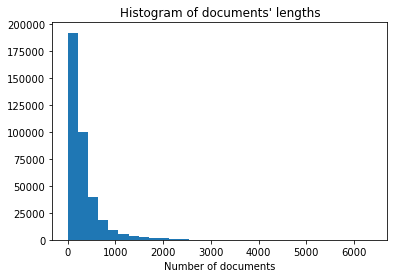

In [58]:
plt.hist(trial_lengths, bins=30)
plt.xlabel('Document length (word count)')
plt.xlabel('Number of documents')
plt.title('Histogram of documents\' lengths')
pd.DataFrame(data=trial_lengths).describe()

In [59]:
query_lengths = []
for query_text in queries[QUERY_TEXT].to_list():
    query_length = len(word_tokenize(query_text))
    if query_length > 0:
        query_lengths.append(query_length)

,0
count,75.000000
mean,156.226667
std,45.418348
min,58.000000
25%,134.000000
50%,154.000000
75%,181.500000
max,263.000000


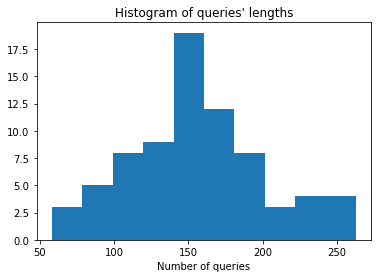

In [60]:
plt.hist(query_lengths, bins=10)
plt.xlabel('Query length (word count)')
plt.xlabel('Number of queries')
plt.title('Histogram of queries\' lengths')
pd.DataFrame(data=query_lengths).describe()

## Evaluation metrics
- precision
- reciprocal rank
- NDCG

In [61]:
def precision(retrieved_docs, label2docs, n=10):
    relevant_docs = label2docs[ELIGIBLE] + label2docs[EXCLUDED]
    
    relevant_retrieved_docs = 0
    for doc in retrieved_docs[:n]:
        relevant_retrieved_docs += 1 if doc in relevant_docs else 0
    
    return relevant_retrieved_docs / n

def reciprocal_rank(retrieced_docs, doc2label):
    for rank, doc in enumerate(retrieced_docs):
        if doc in doc2label and doc2label[doc] in [ELIGIBLE, EXCLUDED]:
            return 1 / (rank + 1)
    else:
        return 0
    
def dcg_for(n_retrieced_docs, doc2label):
    dcg = 0
    for i, doc in enumerate(n_retrieced_docs):
        position = i + 1
        if doc in doc2label:
            dcg += doc2label[doc] / np.log2(position) if position != 1 else doc2label[doc]

    return dcg
    
def ndcg(retrieved_docs, doc2label, label2docs, n=10):
    dcg = dcg_for(retrieved_docs[:n], doc2label)

    relevant_docs_ordered_by_relevance = label2docs[ELIGIBLE] + label2docs[EXCLUDED]
    ideal_dcg = dcg_for(relevant_docs_ordered_by_relevance[:n], doc2label)
    
    return dcg / ideal_dcg

# Retrieve documents with ElasticSearch

### Helper functions to create ES query and retrieve doc ids

In [62]:
def es_query_for(query_text, max_size = MAX_NUMBER_OF_RETRIEVED_DOCS):
    return {
        "size": max_size,
        "query": {
            "bool": {
                "should": [
                    {"match": {"content": query_text}}
                ] 
                ,"minimum_should_match": 1,
                "boost": 1.0
            },
        }
    }

def es_search(es_query, es, index):
    query_results = es.search(index=index, body=es_query)
    return [hit['_id'] for hit in query_results['hits']['hits']]

def retrieved_docs_for(query_id, es, index=INDEX):
    es_query = es_query_for(query_text_for(query_id))
    return es_search(es_query, es, index)

#### Helper functions to store query evaluation metrics

In [63]:
evaluation_metrics = ['precision10', 'reciprocal_rank10', 'ndcg5', 'ndcg10']

Metrics = namedtuple('Metrics', evaluation_metrics)

def df_from(metrics):
    data = [ [m.precision10, m.reciprocal_rank10, m.ndcg5, m.ndcg10] for m in metrics ]
    df = pd.DataFrame(data, columns = evaluation_metrics)
    df.index = df.index + 1
    return df

## Retrieval methods

### Retrieve 10k docs with default elastic-search retrieval method

In [64]:
queries_metrics = []
retrieved_docs_per_query = {}
for query_id in tqdm(queries[QUERY_ID].unique()):
    retrieved_docs = retrieved_docs_for(query_id, es)
    doc2label = doc2label_for(query_id, qrels)
    label2docs = label2docs_for(query_id, qrels)
    
    retrieved_docs_per_query[query_id] = retrieved_docs
    
    metrics = Metrics(
        precision10=precision(retrieved_docs, label2docs),
        reciprocal_rank10=reciprocal_rank(retrieved_docs, doc2label),
        ndcg5=ndcg(retrieved_docs, doc2label, label2docs, n=5),
        ndcg10=ndcg(retrieved_docs, doc2label, label2docs, n=10),
    )
    
    queries_metrics.append(metrics)
    
df_from(queries_metrics).describe()

100%|██████████| 75/75 [02:01<00:00,  1.62s/it]


,precision10,reciprocal_rank10,ndcg5,ndcg10
count,75.000000,75.000000,75.000000,75.000000
mean,0.260000,0.509278,0.386254,0.369811
std,0.250405,0.358396,0.400757,0.296927
min,0.000000,0.038462,0.000000,0.000000
25%,0.000000,0.166667,0.000000,0.146912
50%,0.200000,0.500000,0.280772,0.295966
75%,0.450000,1.000000,0.542192,0.519286
max,0.900000,1.000000,1.877215,1.317917


# Retrieval methods comparison

### Helper functions to index 10k docs based on given similarity script

In [65]:
def mapping_for(similarity_script):
    return {
        "settings":{
            "index":{
                "number_of_shards":1,
                "number_of_replicas":1
            },
            "similarity": {
                "scripted_bm25": {
                    "type": "scripted",
                    "script": {
                        "source": similarity_script
                    }
                }
            }
        },
        "mappings":{
            "properties":{
                "content":{
                    "type":"text",
                    "fielddata":True,
                    "term_vector":"with_positions_offsets_payloads",
                    "store":True,
                    "analyzer":"whitespace",
                    "similarity": "scripted_bm25"
                }
            }
        }
    }

def index_docs_using_custom_similarity(
    retrieved_docs_per_query,
    similarity_name,
    doc2content=doc2content,
    index_prefix=RETRIEVED_DOCS_INDEX,
):
    similarity_index_prefix = f'{index_prefix}-{similarity_name}'
    for query_id, retrieved_docs in retrieved_docs_per_query.items():
    
        index = f'{similarity_index_prefix}-{query_id}'
        
        es.indices.delete(index) if es.indices.exists(index=index) else None 
        es.indices.create(index=index, ignore=400, body=mapping_for(SIMILARITY_BY_NAME[similarity_name]))
        
        docs = [
            {'_index': index, '_id': doc_id, 'content': doc2content[doc_id]} 
            for doc_id in retrieved_docs
        ]

        bulk(es, docs)
        
    return similarity_index_prefix

### Helper functions to get the queries metrics dataframe for a given index

In [66]:
def queries_metrics_df_for(index_prefix):
    queries_metrics = []
    for query_id in tqdm(queries[QUERY_ID].unique()):
        retrieved_docs = retrieved_docs_for(query_id, es, f'{index_prefix}-{query_id}')
        doc2label = doc2label_for(query_id, qrels)
        label2docs = label2docs_for(query_id, qrels)
        
        metrics = Metrics(
            precision10=precision(retrieved_docs, label2docs),
            reciprocal_rank10=reciprocal_rank(retrieved_docs, doc2label),
            ndcg5=ndcg(retrieved_docs, doc2label, label2docs, n=5),
            ndcg10=ndcg(retrieved_docs, doc2label, label2docs, n=10),
        )
        
        queries_metrics.append(metrics)
        
    return df_from(queries_metrics)

## Evaluation: Elastic search default method

### create an index for each query's retrieved docs using the default BM25 method

In [67]:
default_index_prefix = f'{RETRIEVED_DOCS_INDEX}-{BM25_DEFAULT}'

for query_id, retrieved_docs in retrieved_docs_per_query.items():
    
    index = f'{default_index_prefix}-{query_id}'
    es.indices.create(index=index, ignore=400, body=mapping)
    docs10k = [
                {'_index': index, '_id': doc_id, 'content': doc2content[doc_id]} 
                for doc_id in retrieved_docs
            ]

    bulk(es, docs10k)


In [68]:
default_bm25_metrics = queries_metrics_df_for(default_index_prefix)
default_bm25_metrics.describe()

100%|██████████| 75/75 [02:30<00:00,  2.01s/it]


,precision10,reciprocal_rank10,ndcg5,ndcg10
count,75.000000,75.000000,75.000000,75.000000
mean,0.262667,0.538387,0.400433,0.384488
std,0.241489,0.354550,0.363483,0.277358
min,0.000000,0.018519,0.000000,0.000000
25%,0.000000,0.250000,0.156917,0.170462
50%,0.200000,0.500000,0.345651,0.334111
75%,0.400000,1.000000,0.574071,0.528115
max,0.900000,1.000000,1.834710,1.240199


## Baseline: Robertson BM25 
- cannot work with Elastic search because it returns negative scores which is not allowed

In [ ]:
# bm25_variant_index_prefix = index_docs_using_custom_similarity(retrieved_docs_per_query, ROBERTSON_BM25)
# bm25_variant_metrics = queries_metrics_df_for(bm25_variant_index_prefix)
# bm25_variant_metrics.describe()

## Evaluation: BM25+

In [71]:
bm25_variant_index_prefix = index_docs_using_custom_similarity(retrieved_docs_per_query, BM25_PLUS)
bm25_variant_metrics = queries_metrics_df_for(bm25_variant_index_prefix)
bm25_variant_metrics.describe()

100%|██████████| 75/75 [02:02<00:00,  1.64s/it]


,precision10,reciprocal_rank10,ndcg5,ndcg10
count,75.000000,75.000000,75.000000,75.000000
mean,0.250667,0.594562,0.435182,0.418149
std,0.233871,0.372853,0.440934,0.314972
min,0.000000,0.045455,0.000000,0.000000
25%,0.100000,0.250000,0.163927,0.196034
50%,0.200000,0.500000,0.305466,0.346882
75%,0.350000,1.000000,0.603879,0.568333
max,0.800000,1.000000,2.207444,1.583520


## Evaluation: TFldpIDF

In [86]:
bm25_variant_index_prefix = index_docs_using_custom_similarity(retrieved_docs_per_query, TFldpIDF)
bm25_variant_metrics = queries_metrics_df_for(bm25_variant_index_prefix)
bm25_variant_metrics.describe()

100%|██████████| 75/75 [02:36<00:00,  2.08s/it]


,precision10,reciprocal_rank10,ndcg5,ndcg10
count,75.000000,75.000000,75.000000,75.000000
mean,0.314667,0.551758,0.391466,0.374653
std,0.214787,0.369072,0.330480,0.295046
min,0.000000,0.034483,0.000000,0.000000
25%,0.200000,0.250000,0.138009,0.161611
50%,0.300000,0.500000,0.357534,0.322761
75%,0.500000,1.000000,0.573160,0.494245
max,0.900000,1.000000,1.294883,1.297742


## Evaluation: BM25L

In [81]:
bm25_variant_index_prefix = index_docs_using_custom_similarity(retrieved_docs_per_query, BM25L)
bm25_variant_metrics = queries_metrics_df_for(bm25_variant_index_prefix)
bm25_variant_metrics.describe()

100%|██████████| 75/75 [02:21<00:00,  1.89s/it]


,precision10,reciprocal_rank10,ndcg5,ndcg10
count,75.000000,75.000000,75.000000,75.000000
mean,0.250667,0.550152,0.344414,0.335848
std,0.207542,0.377987,0.298590,0.254477
min,0.000000,0.040000,0.000000,0.000000
25%,0.100000,0.200000,0.080189,0.151945
50%,0.200000,0.500000,0.326690,0.294325
75%,0.400000,1.000000,0.526882,0.475986
max,0.900000,1.000000,1.290886,1.183512


## Evaluation: ATIRE

In [82]:
bm25_variant_index_prefix = index_docs_using_custom_similarity(retrieved_docs_per_query, ATIRE)
bm25_variant_metrics = queries_metrics_df_for(bm25_variant_index_prefix)
bm25_variant_metrics.describe()

100%|██████████| 75/75 [02:35<00:00,  2.08s/it]


,precision10,reciprocal_rank10,ndcg5,ndcg10
count,75.000000,75.000000,75.000000,75.000000
mean,0.250667,0.594562,0.435182,0.418149
std,0.233871,0.372853,0.440934,0.314972
min,0.000000,0.045455,0.000000,0.000000
25%,0.100000,0.250000,0.163927,0.196034
50%,0.200000,0.500000,0.305466,0.346882
75%,0.350000,1.000000,0.603879,0.568333
max,0.800000,1.000000,2.207444,1.583520


## Evaluation: Lucene accurate

In [84]:
bm25_variant_index_prefix = index_docs_using_custom_similarity(retrieved_docs_per_query, LUCENE_ACCURATE)
bm25_variant_metrics = queries_metrics_df_for(bm25_variant_index_prefix)
bm25_variant_metrics.describe()

100%|██████████| 75/75 [02:38<00:00,  2.11s/it]


,precision10,reciprocal_rank10,ndcg5,ndcg10
count,75.000000,75.000000,75.000000,75.000000
mean,0.333333,0.569339,0.400697,0.392067
std,0.226807,0.376123,0.334729,0.296532
min,0.000000,0.027778,0.000000,0.000000
25%,0.200000,0.200000,0.143370,0.178111
50%,0.300000,0.500000,0.431879,0.372505
75%,0.500000,1.000000,0.581369,0.517049
max,0.900000,1.000000,1.430514,1.409426
